# Acquire

Let's acquire the parking citations data from our file.
1. Import libraries.
1. Load the dataset.
1. Display the shape and first/last 2 rows.
1. Display general infomation about the dataset - w/ the # of unique values in each column.
1. Display the number of missing values in each column.
1. Descriptive statistics for all numeric features.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import folium
import unicodedata
import re
import json

from tqdm.notebook import tqdm

# Insert path to the source folder.
sys.path.insert(1, 'src/')
import acquire
import prepare

# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

## Street Sweeper Citations
Data: [Los Angeles Parking Citations](https://www.kaggle.com/cityofLA/los-angeles-parking-citations)<br>
Load the dataset and filter for:
- Citations issued from 2017-01-01 to 2020-12-22.
- Street Sweeping violations - `Violation Description` == __"NO PARK/STREET CLEAN"__

In [2]:
# Load the data
df = acquire.get_sweep_data()

In [3]:
# Display the shape and dtypes of each column
print(df.shape)
df.info()

(1882464, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882464 entries, 0 to 1882463
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Ticket number           object 
 1   Issue Date              object 
 2   Issue time              float64
 3   Meter Id                object 
 4   Marked Time             float64
 5   RP State Plate          object 
 6   Plate Expiry Date       float64
 7   VIN                     float64
 8   Make                    object 
 9   Body Style              object 
 10  Color                   object 
 11  Location                object 
 12  Route                   object 
 13  Agency                  float64
 14  Violation code          object 
 15  Violation Description   object 
 16  Fine amount             float64
 17  Latitude                float64
 18  Longitude               float64
 19  Agency Description      object 
 20  Color Description       object 
 21  Body Style Descri

In [4]:
# Display the first two citations
df.head(2)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
0,4343388033,2018-10-25T00:00:00.000,1204.0,NaN,NaN,CA,201802.0,NaN,MNNI,PA,...,00472,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.477238e+06,1.854036e+06,NaN,NaN,NaN
1,4343388055,2018-10-25T00:00:00.000,1211.0,NaN,NaN,CA,201902.0,NaN,TOYT,PA,...,00472,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.477999e+06,1.851994e+06,NaN,NaN,NaN


In [5]:
# Display the last two citations
df.tail(2)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
1882462,4522167742,2020-12-22T00:00:00.000,1046.0,NaN,NaN,CA,202010.0,NaN,SUBA,PA,...,00300,53.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.380484e+06,1.895415e+06,53 - DOT - VALLEY,GREY,PASSENGER CAR
1882463,4523214220,2020-12-22T00:00:00.000,833.0,NaN,NaN,CA,NaN,NaN,JAGU,PA,...,00553,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,6.478186e+06,1.808237e+06,55 - DOT - SOUTHERN,BEIGE,PASSENGER CAR


In [6]:
# Display descriptive statistics of numeric columns
df.describe()

,Issue time,Marked Time,Plate Expiry Date,VIN,Agency,Fine amount,Latitude,Longitude
count,1.882426e+06,0.0,1.719841e+06,0.0,1.882464e+06,1.882460e+06,1.882464e+06,1.882464e+06
mean,1.013076e+03,NaN,1.922022e+05,NaN,5.338664e+01,7.299998e+01,5.919254e+06,1.701929e+06
std,1.861187e+02,NaN,4.308395e+04,NaN,1.997974e+00,1.546120e-02,1.762232e+06,4.860292e+05
min,5.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00,5.300000e+01,9.999900e+04,9.999900e+04
25%,8.420000e+02,NaN,2.018010e+05,NaN,5.100000e+01,7.300000e+01,6.424639e+06,1.825621e+06
50%,1.018000e+03,NaN,2.018100e+05,NaN,5.400000e+01,7.300000e+01,6.452519e+06,1.843891e+06
75%,1.209000e+03,NaN,2.019090e+05,NaN,5.500000e+01,7.300000e+01,6.472699e+06,1.859551e+06
max,2.355000e+03,NaN,9.201020e+05,NaN,5.800000e+01,7.300000e+01,6.513045e+06,1.940266e+06


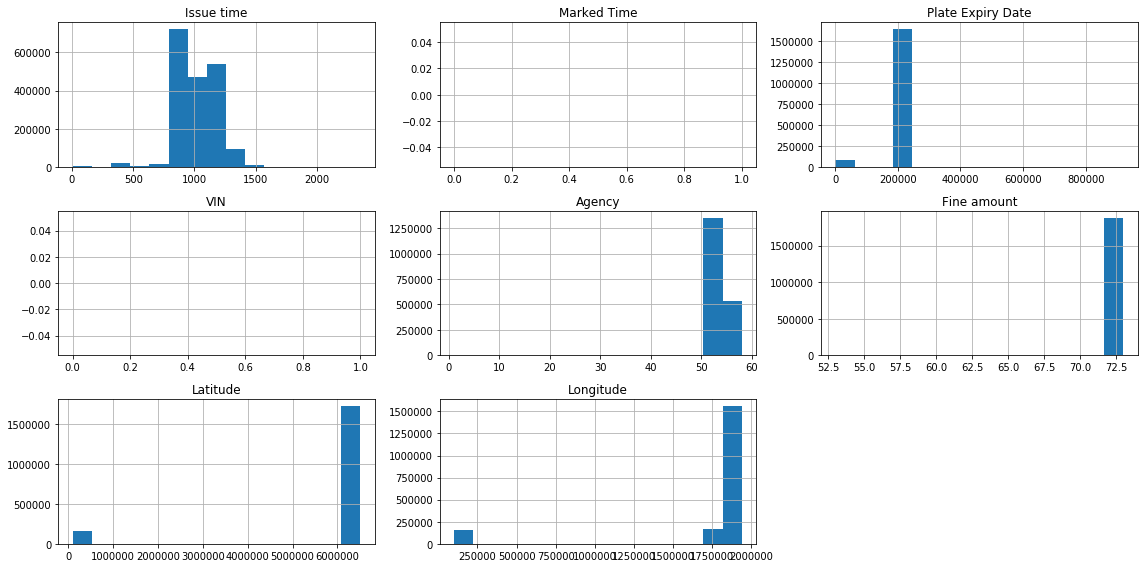

In [7]:
df.hist(figsize=(16, 8), bins=15)
plt.tight_layout();

__Initial findings__
- `Issue time` and `Marked Time` are quasi-normally distributed. Note: Poisson Distribution
- It's interesting to see the distribution of our activity on earth follows a normal distribution.
- Agencies 50+ write the most parking citations.
- Most fine amounts are less than $100.00
- There are a few null or invalid license plates.

# Prepare

- Remove spaces + capitalization from each column name.
- Cast `Plate Expiry Date` to datetime data type.
- Cast `Issue Date` and `Issue Time` to datetime data types.
- Drop columns missing >=74.42\% of their values. 
- Drop missing values.
- Transform Latitude and Longitude columns from NAD1983StatePlaneCaliforniaVFIPS0405 feet projection to EPSG:4326 World Geodetic System 1984: used in GPS [Standard]
- Filter data for street sweeping citations only.

In [8]:
# Prepare the data using a function stored in prepare.py
df_citations = prepare.prep_sweep_data(df)

# Display the first two rows
df_citations.head(2)

,issue_date,issue_time,rp_state_plate,plate_expiry_date,make,body_style,color,location,route,agency,violation_description,fine_amount,latitude,longitude,day_of_week,issue_year,issue_hour,issue_minute
0,2017-01-03,10:53:00,CA,2017-07-01,VOLK,PA,MR,2400 PATRICIA AVENUE,00108,51,NO PARK/STREET CLEAN,73.0,34.0452,-118.4190,Tuesday,2017,10,53
1,2017-01-03,11:03:00,CA,2016-07-01,TOYT,PA,BK,121 76TH PL E,00553,55,NO PARK/STREET CLEAN,73.0,33.9705,-118.2735,Tuesday,2017,11,3


In [9]:
# Check the column data types and non-null counts.
df_citations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634569 entries, 0 to 1634568
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   issue_date             1634569 non-null  object 
 1   issue_time             1634569 non-null  object 
 2   rp_state_plate         1634569 non-null  object 
 3   plate_expiry_date      1634569 non-null  object 
 4   make                   1634569 non-null  object 
 5   body_style             1634569 non-null  object 
 6   color                  1634569 non-null  object 
 7   location               1634569 non-null  object 
 8   route                  1634569 non-null  object 
 9   agency                 1634569 non-null  int64  
 10  violation_description  1634569 non-null  object 
 11  fine_amount            1634569 non-null  float64
 12  latitude               1634569 non-null  float64
 13  longitude              1634569 non-null  float64
 14  day_of_week       

# Exploration

## What time(s) are Street Sweeping citations issued?
#### Citation Times

In [10]:
# Filter street sweeping data for citations issued between
# 8am and 2pm, 8 and 14 respectively.

df_citation_times = df_citations.loc[(df_citations.issue_hour >= 8)&(df_citations.issue_hour < 14)]

What time are most parking citations issued?

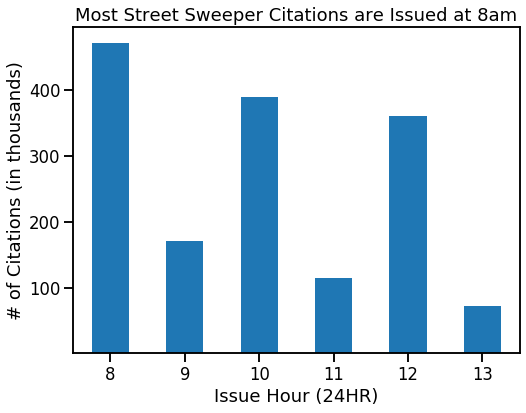

In [11]:
sns.set_context('talk')

# Issue Hour Plot
df_citation_times.issue_hour.value_counts().sort_index().plot.bar(figsize=(8, 6))

# Axis labels
plt.title('Most Street Sweeper Citations are Issued at 8am')
plt.xlabel('Issue Hour (24HR)')
plt.ylabel('# of Citations (in thousands)')

# Chart Formatting
plt.xticks(rotation=0)
plt.yticks(range(100_000, 400_001,100_000), ['100', '200', '300', '400'])
plt.show()

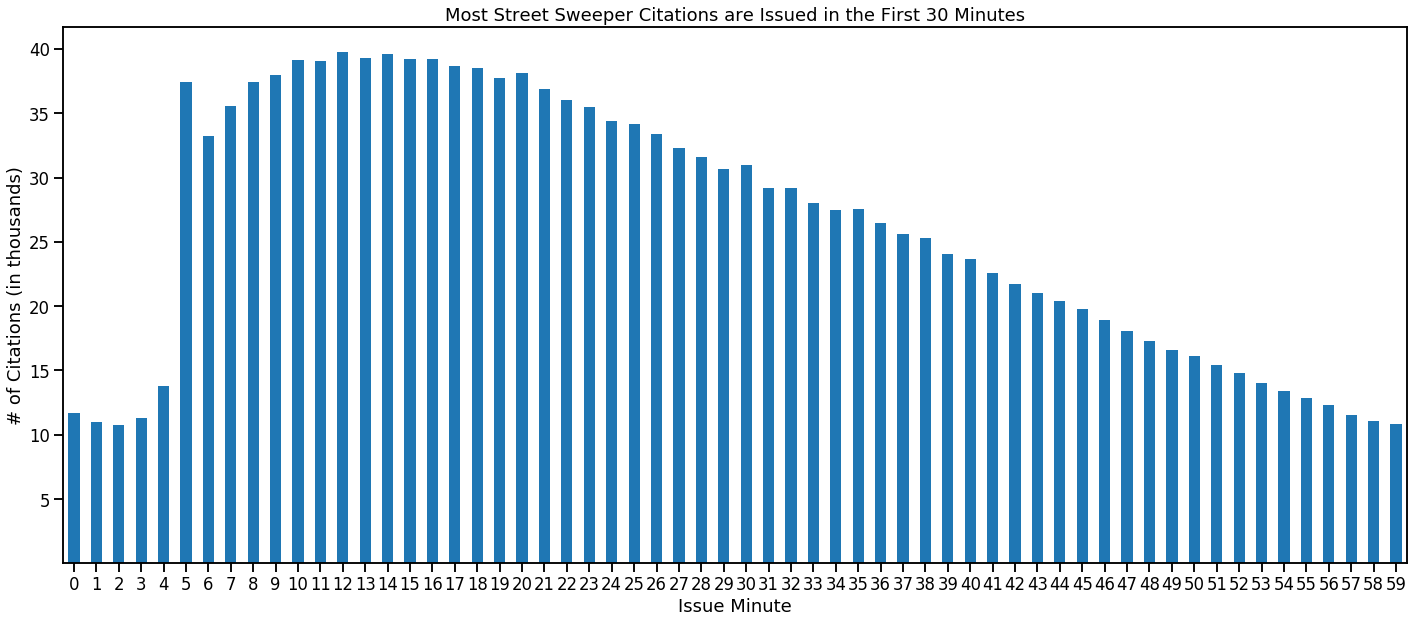

In [12]:
sns.set_context('talk')

# Issue Minute Plot
df_citation_times.issue_minute.value_counts().sort_index().plot.bar(figsize=(20, 9))

# Axis labels
plt.title('Most Street Sweeper Citations are Issued in the First 30 Minutes')
plt.xlabel('Issue Minute')
plt.ylabel('# of Citations (in thousands)')
# plt.axvspan(0, 30, facecolor='grey', alpha=0.1)

# Chart Formatting
plt.xticks(rotation=0)
plt.yticks(range(5_000, 40_001, 5_000), ['5', '10', '15', '20', '25', '30', '35', '40'])
plt.tight_layout()
plt.show()

In [13]:
# sns.set_context('talk')

# df_citations.issue_time.value_counts().resample('s').sum().plot(figsize=(12, 6))

# plt.title('Most citations are issued during the hours of 8am, 10am, and 12pm')
# plt.ylabel('# of Citations');

## On average, what is the daily revenue generated from Street Sweeping citations?
### Daily Street Sweeping Citation Revenue
Street sweeping citations increased in 2020.

> __Anomaly 1__: What happened inbetween June of 2019 and January of 2020?<br>
>
> __Anomaly 2__: Between March 2020 and October 2020 a Local Emergency was Declared by the Mayor of Los Angeles in response to COVID-19. Street Sweeping was halted to help Angelenos Shelter in Place. _Street Sweeping resumed on 10/15/2020_.

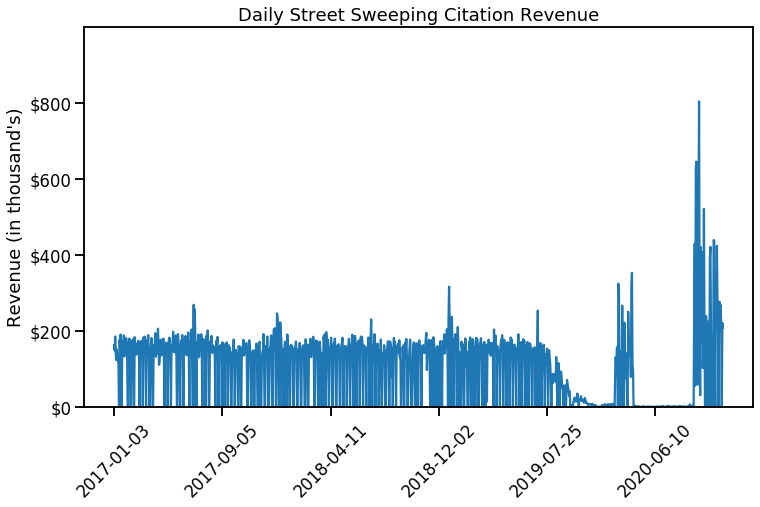

In [63]:
sns.set_context('talk')

# Plot daily revenue from street sweeping citations
df_citations.groupby('issue_date').fine_amount.sum().plot(figsize=(12, 7))

plt.title('Daily Street Sweeping Citation Revenue')
plt.xlabel('')
plt.ylabel('Revenue (in thousand\'s)')

plt.xticks(rotation=45)
plt.yticks(range(0, 1_000_000, 200_000), ['$0', '$200', '$400', '$600', '$800',])
plt.ylim(0, 1_000_000);

## What state has the most Street Sweeping violators?
### License Plate
Over 90% of all street sweeping citations are issued to California Residents.

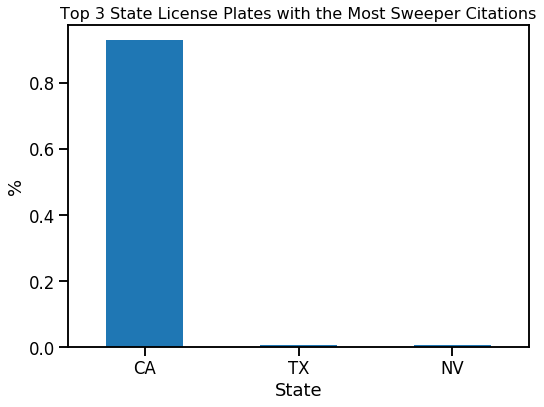

In [56]:
sns.set_context('talk')

fig = df_citations.rp_state_plate.value_counts(normalize=True).nlargest(3).plot.bar(figsize=(8, 6))

# Chart labels
plt.title('Top 3 State License Plates with the Most Sweeper Citations', fontsize=16)
plt.xlabel('State')
plt.ylabel('%')

# Tick Formatting
plt.xticks(rotation=0)

plt.tight_layout();

## Citation Location

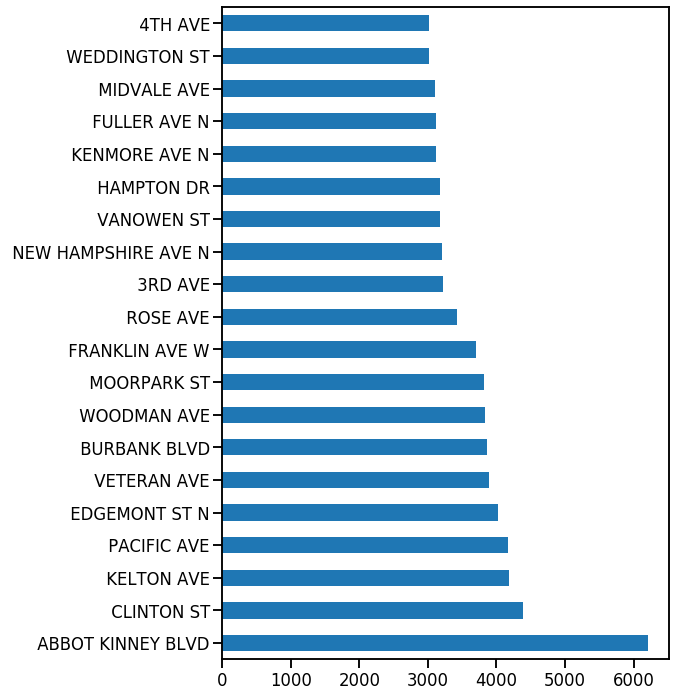

In [49]:
df_citations.location.str.replace('^[\d]{2,}', '').value_counts().nlargest(20).plot.barh(figsize=(8, 12));

In [17]:
df_citations.latitude.value_counts()

27.5175    138015
34.1504      4169
34.1939      3823
34.1003      3620
34.1649      3417
            ...  
34.2982         1
33.9003         1
33.9648         1
33.7273         1
34.2978         1
Name: latitude, Length: 4816, dtype: int64

In [18]:
df_citations.longitude.value_counts()

-137.9131    138015
-118.3878      4238
-118.2929      3755
-118.2961      3631
-118.3157      3500
              ...  
-118.1609         1
-118.5727         1
-118.5359         1
-118.5636         1
-118.6393         1
Name: longitude, Length: 4621, dtype: int64

## Post-Covid Enforcement Analysis

In [19]:
df_covid = df_citations.loc[df_citations.issue_date >= '2020-10-15']
df_covid.reset_index(drop=True, inplace=True)

In [20]:
df_covid.head()

,issue_date,issue_time,rp_state_plate,plate_expiry_date,make,body_style,color,location,route,agency,violation_description,fine_amount,latitude,longitude,day_of_week,issue_year,issue_hour,issue_minute
0,2020-10-15,12:38:00,CA,2021-03-01,MITS,PA,WT,651 ARDMORE AV S,478R2,54,NO PARK/STREET CLEAN,73.0,34.0617,-118.3020,Thursday,2020,12,38
1,2020-10-15,09:34:00,CA,2021-09-01,BMW,PA,BK,2010 LINDEN AVE,00132,51,NO PARK/STREET CLEAN,73.0,33.9940,-118.4571,Thursday,2020,9,34
2,2020-10-15,09:23:00,NJ,2017-09-01,HOND,PA,SL,1845 BUTLER AV,00152,51,NO PARK/STREET CLEAN,73.0,34.0416,-118.4485,Thursday,2020,9,23
3,2020-10-15,09:24:00,CA,2021-05-01,TOYT,PA,BK,5024 CLEON AVE,00323,53,NO PARK/STREET CLEAN,73.0,34.1618,-118.3681,Thursday,2020,9,24
4,2020-10-15,09:44:00,CA,2021-02-01,NISS,PA,GY,1519 HAZELWOOD AVE,00600,56,NO PARK/STREET CLEAN,73.0,34.1235,-118.2148,Thursday,2020,9,44


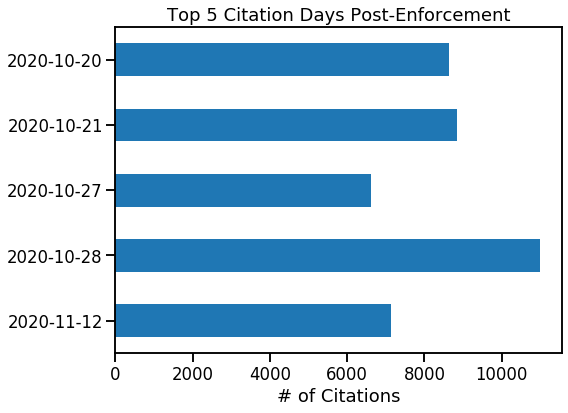

In [21]:
df_covid.issue_date.value_counts(ascending=False).head(5).sort_index(ascending=False).plot.barh(figsize=(8, 6))

plt.title('Top 5 Citation Days Post-Enforcement')
plt.xlabel('# of Citations')
plt.show()

In [22]:
df_2017 = df_citations.loc[df_citations.issue_date.between('2017-01-01', '2017-12-31')]
df_2018 = df_citations.loc[df_citations.issue_date.between('2018-01-01', '2018-12-31')]
df_2019 = df_citations.loc[df_citations.issue_date.between('2019-01-01', '2019-12-31')]
df_2020 = df_citations.loc[df_citations.issue_date.between('2020-10-01', '2020-12-31')]

In [23]:
df_2017.groupby('issue_date').fine_amount.sum().describe()

count       307.000000
mean     128608.846906
std       67393.429200
min          73.000000
25%      125852.000000
50%      154322.000000
75%      169615.500000
max      268713.000000
Name: fine_amount, dtype: float64

In [24]:
df_2018.groupby('issue_date').fine_amount.sum().describe()

count       317.000000
mean     118808.536278
std       70563.662969
min          73.000000
25%       76139.000000
50%      149796.000000
75%      164834.000000
max      316455.000000
Name: fine_amount, dtype: float64

In [25]:
df_2019.groupby('issue_date').fine_amount.sum().describe()

count       279.000000
mean      88072.014337
std       73513.673235
min          73.000000
25%        5475.000000
50%      110887.000000
75%      158994.000000
max      253310.000000
Name: fine_amount, dtype: float64

In [26]:
df_2020.groupby('issue_date').fine_amount.sum().describe()

count        62.000000
mean     208652.516129
std      192977.902163
min          73.000000
25%        3358.000000
50%      208232.500000
75%      284134.250000
max      803146.000000
Name: fine_amount, dtype: float64

### Hypothesis Test 1

**Initial Query**
Was the amount of citations issued in October 2020 significantly greater than previous Octobers?

**Statistical Test**

$H_0$: There is no significant difference...

$H_a$: There is a significant difference...

# Conclusions